In [28]:
%matplotlib inline
from dl_toolbox.utils import show_detections, unnormalize
import hydra
from omegaconf import OmegaConf
import pytorch_lightning as pl
from dl_toolbox.callbacks import PredictionsVisu
from dl_toolbox.modules import FCOS
from dl_toolbox.networks import ViTDet
import torch

with hydra.initialize(version_base="1.3", config_path="./configs"):
    cfg = hydra.compose(config_name="default_train.yaml", overrides=["+experiment=xview"])

#print(OmegaConf.to_yaml(cfg))
pl.seed_everything(cfg.seed)
datamodule = hydra.utils.instantiate(cfg.datamodule)

def gpu_mem_used():
    free, total = torch.cuda.mem_get_info(torch.device('cuda:0'))
    mem_used_MB = (total - free) / 1024 ** 2
    return mem_used_MB

Seed set to 1


In [2]:
model = ViTDet(
    backbone=cfg.module.model.backbone,
    out_channels=cfg.module.model.out_channels,
    add_extra_blocks=cfg.module.model.add_extra_blocks,
    num_classes=len(datamodule.class_list)
)

module_state_dict = torch.load(
    '/data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt',
    #weights_only=True
)['state_dict']

def remove_prefix(text, prefix):
    # Reproduces python3.9 str.removeprefix()
    return text[text.startswith(prefix) and len(prefix):]
model_state_dict = {remove_prefix(key, 'model.'): val for key, val in module_state_dict.items() if key.startswith('model')}

model.load_state_dict(model_state_dict)
model.to('cuda')
model.eval()

anchors, anchor_sizes = FCOS.get_anchors(model, 672, [128, 256, 512])

datamodule.prepare_data()
datamodule.setup(stage='fit')

/tmp/ipykernel_213454/2759533035.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  module_state_dict = torch.load(


loading annotations into memory...
Done (t=2.75s)
creating index...
index created!


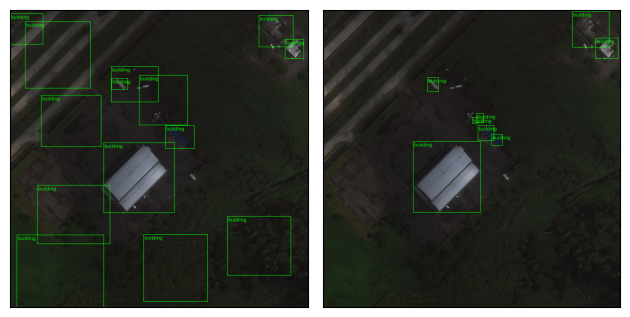

In [26]:
elem = datamodule.val_set[10]
x = elem['image'][None].to('cuda')
int_imgs = unnormalize(x.detach().cpu())
with torch.no_grad():
    cls_logits, bbox_reg, centerness = model(x)
    b,c,h,w = x.shape           
    preds = FCOS.post_process_batch(
        cls_logits.detach(),
        bbox_reg.detach(),
        centerness.detach(),
        (h,w),
        anchors.to('cuda'),
        pre_nms_thresh=0.2,
        pre_nms_top_n=100000,
        nms_thresh=0.15,
        fpn_post_nms_top_n=50,
        min_size=10,
    )
    preds = [{k: v.detach().cpu() for k, v in p.items()} for p in preds]
show_detections(int_imgs*2, preds+[elem['target']], class_list=datamodule.class_list)

In [27]:
from pprint import pformat

module = hydra.utils.instantiate(
    cfg.module,
    class_list=datamodule.class_list
)
module.pre_nms_thresh=0.2
module.pre_nms_top_n=100000
module.nms_thresh=0.15
module.fpn_post_nms_top_n=50
module.min_size=10

cfg.trainer.default_root_dir='/data/'

class print_val_MAP(pl.Callback):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def on_validation_epoch_end(self, trainer, pl_module):
        mapmetrics = pl_module.map_metric.compute()
        print(pformat(mapmetrics))

trainer = hydra.utils.instantiate(cfg.trainer)(
    callbacks=[print_val_MAP()],
    #limit_val_batches=2
)

trainer.validate(
    module,
    datamodule=datamodule,
    ckpt_path='/data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt',
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..


loading annotations into memory...
Done (t=2.41s)
creating index...
index created!


Restoring states from the checkpoint path at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /data/outputs/xview/2025-02-05_205903/0/checkpoints/last.ckpt


Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:24<00:00,  5.95it/s]{'classes': tensor(1, dtype=torch.int32),
 'map': tensor(0.0811),
 'map_50': tensor(0.2431),
 'map_75': tensor(0.0318),
 'map_large': tensor(0.0778),
 'map_medium': tensor(0.1109),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.0211),
 'mar_1': tensor(0.0077),
 'mar_10': tensor(0.0469),
 'mar_100': tensor(0.1266),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.1558),
 'mar_medium': tensor(0.1726),
 'mar_small': tensor(0.0339)}
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:25<00:00,  5.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metri

[{'Loss/val': 1.2666479349136353, 'map/val': 0.08114106953144073}]